In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [81]:
df = pd.read_csv("/kaggle/input/london-bike-sharing-dataset/london_merged.csv", parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [82]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [83]:
df.shape

(17414, 10)

In [84]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:, 1:2]

In [85]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


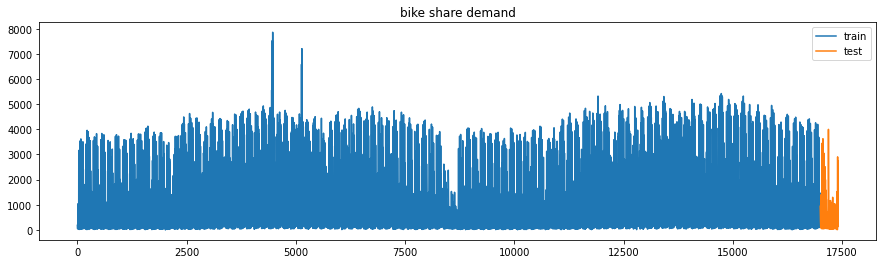

In [86]:
df['cnt'][:17000].plot(figsize=(15, 4), legend=True)
df['cnt'][17000:].plot(figsize=(15, 4), legend=True)
plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

In [87]:
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


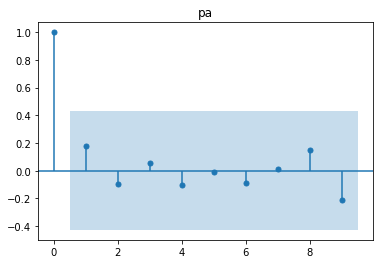

In [88]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=9, method='ols', title='pa').show()

In [89]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train)

In [90]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [91]:
X_train = list()
y_train = list()

for i in range(1, 17000):
    X_train.append(train_scaled[i - 1 : i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [92]:
X_train.shape

(16999, 1)

In [93]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

In [94]:
# RNN 실습하기 - 과거의 정보를 보관한다는 특징
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN

In [95]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1, 1)))
rnn.add(Dense(activation='linear', units=1))

In [96]:
print(rnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 6)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [98]:
rnn.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 18s 1ms/step - loss: 0.0114 - mse: 0.0114
Epoch 2/2
16999/16999 [==============================] - 17s 1ms/step - loss: 0.0069 - mse: 0.0069


In [99]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [100]:
X_test = list()
for i in range(1, 415):
    X_test.append(inputs[i - 1 : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(414, 1, 1)

In [101]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn)

In [102]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

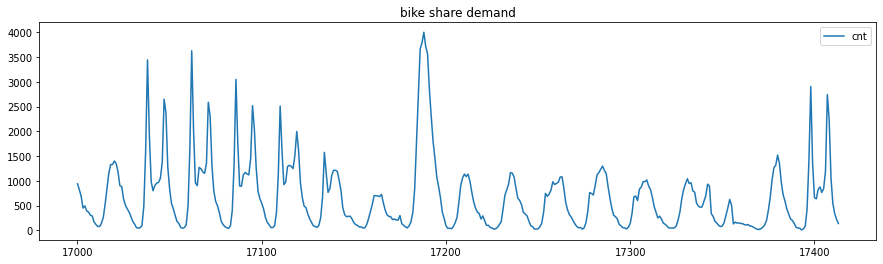

In [103]:
test1.plot(figsize=(15, 4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

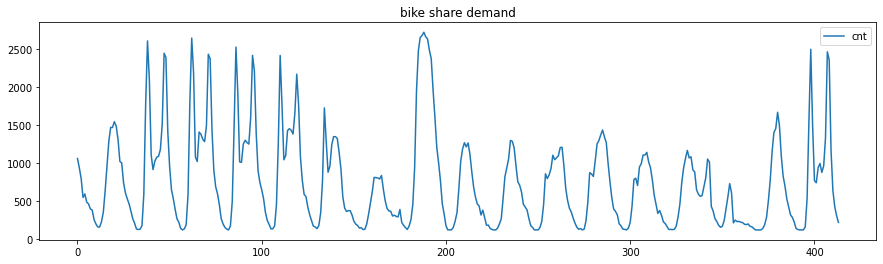

In [104]:
rnn1.plot(figsize=(15, 4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

In [105]:
test = np.array(test)


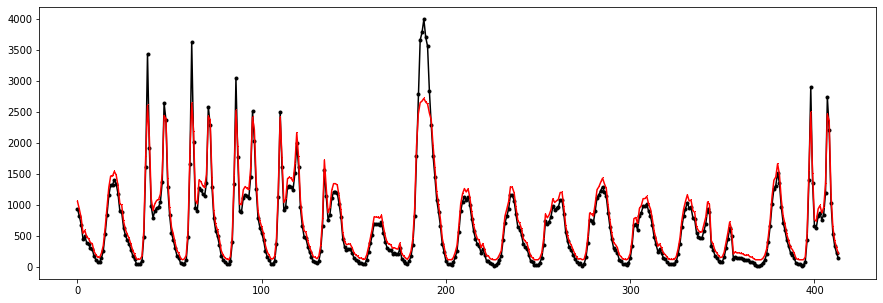

In [113]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='k')
plt.plot(rnn, marker=',', label='rnn', color='r')

In [109]:
## LSTM 시도해보기 -> RNN의 정보 소실을 개선
from keras.layers.recurrent import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1, 1)))
lstm.add(Dense(units=1, activation='linear'))

In [110]:
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [111]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 19s 1ms/step - loss: 0.0110 - mse: 0.0110
Epoch 2/2
16999/16999 [==============================] - 18s 1ms/step - loss: 0.0073 - mse: 0.0073


In [112]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

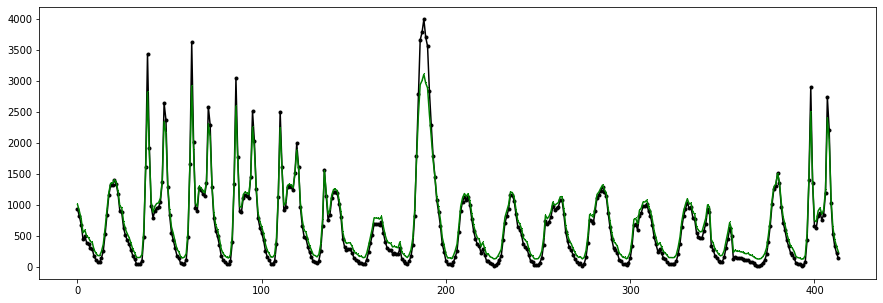

In [115]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='k')
plt.plot(lstm, marker=',', label='LSTM', color='g')

In [126]:
## GRU -> LSTM의 오버피팅 문제를 보완
from keras.layers.recurrent import GRU

gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1, 1)))
gru.add(Dense(units=1, activation='linear'))

In [127]:
gru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 6)                 162       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [128]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 20s 1ms/step - loss: 0.0089 - mse: 0.0089
Epoch 2/2
16999/16999 [==============================] - 19s 1ms/step - loss: 0.0066 - mse: 0.0066


In [129]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

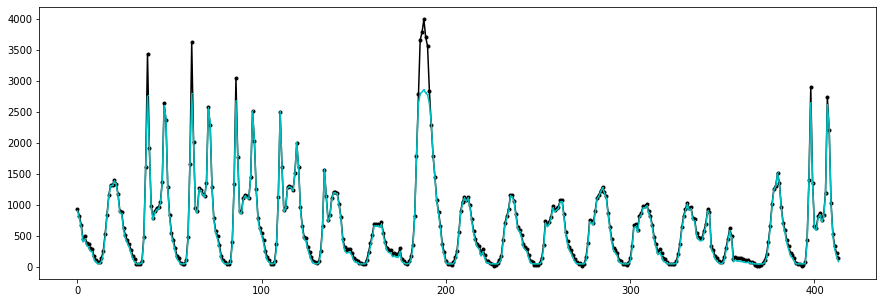

In [130]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='k')
plt.plot(gru, marker=',', label='GRU', color='c')

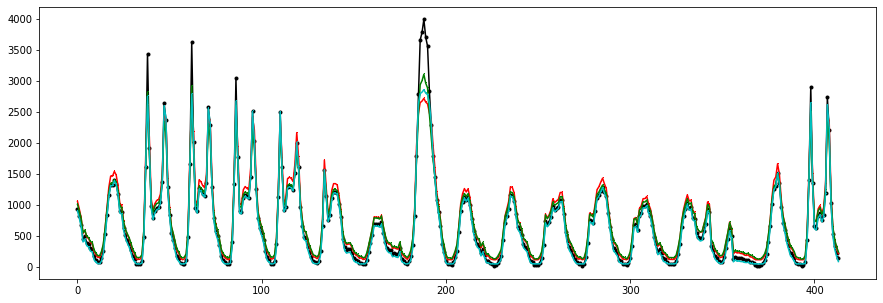

In [131]:
## 모형 3개 비교하기
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='k')
plt.plot(rnn, marker=',', label='rnn', color='r')
plt.plot(lstm, marker=',', label='LSTM', color='g')
plt.plot(gru, marker=',', label='GRU', color='c')


In [132]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [137]:
print("RNN RMSE", RMSE(test, rnn))
print("LSTM RMSE", RMSE(test, lstm))
print("GRU RMSE", RMSE(test, gru))

RNN RMSE 174.09173953268277
LSTM RMSE 141.52399796918652
GRU RMSE 123.8372393214762
